<h1><center>TP3: Perceptron Mutli-Couches</center></h1>

Consigne pour le contrôle continu:


1.   Rendre le TP3 au plus tard le 11 avril (1 par groupe).
2.   Présenter son travail le 28 mars: il est attendu que le groupe présente les résultats du TP2 et du TP3 sur le jeu de données **make_moon**. Il faudra dans une première partie expliquer la construction du code du MLP (Questions 9 et 10 du TP3). Dans une seconde partie, il faut présenter/comparer les résultats des algorithmes perceptron & ADALINE (TP2), régression logistique de sklearn (TP3), MLP de sklearn (TP2) et MLP codé par le groupe (TP3). Il est attendu que les résultats soient commentés.

Deux remarques sur la présentation:

*   Si le MLP codé par le groupe ne fonctionne pas pour la présentation, ce n'est pas grave (c'est quand même mieux si il fonctionne !). Dans ce cas, il faut dire ce que le groupe a fait, où sont les beugs dans le code, les points à améliorer et des idées sur pourquoi cela ne fonctionne pas.
*   Il n'est pas attendu à ce que les résultats sur le jeu de données réel soit donnés pendant la présentation. La dernière partie du TP3 est simplement à rendre pour le 11 avril.




Dans ce TP, nous allons donc implémenter un réseau de neurone simple à une couche cachée à partir de zéro.
Même si vous utiliserez des bibliothèques de deep learning comme Pytorch ou Tensorflow par la suite, l'implémentation d'un réseau à partir de zéro au moins une fois est un exercice extrêmement utile, essentiel pour concevoir et optimiser ses propres modèles efficacement.



In [236]:
# Importations des package utiles
import matplotlib # Pour les tracés
import matplotlib.pyplot as plt
import numpy as np # Pour réaliser des opération sur des matrices efficacement

# Nous utiliserons la bibliothèque sklearn pour comparer notre réseau de neurone
# à celui d'une approche plus simple comme une régression logistique
import sklearn
import sklearn.datasets
import sklearn.linear_model

from sklearn.model_selection import train_test_split

import random

from sklearn.utils import shuffle

# Pour afficher les plots inline et régler l'affichage
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# Generation d'un dataset

On reprend le même jeu de données que précédemment.

In [158]:
X, y = sklearn.datasets.make_moons(n_samples=200, noise=0.1, random_state=42)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.4, random_state=42)

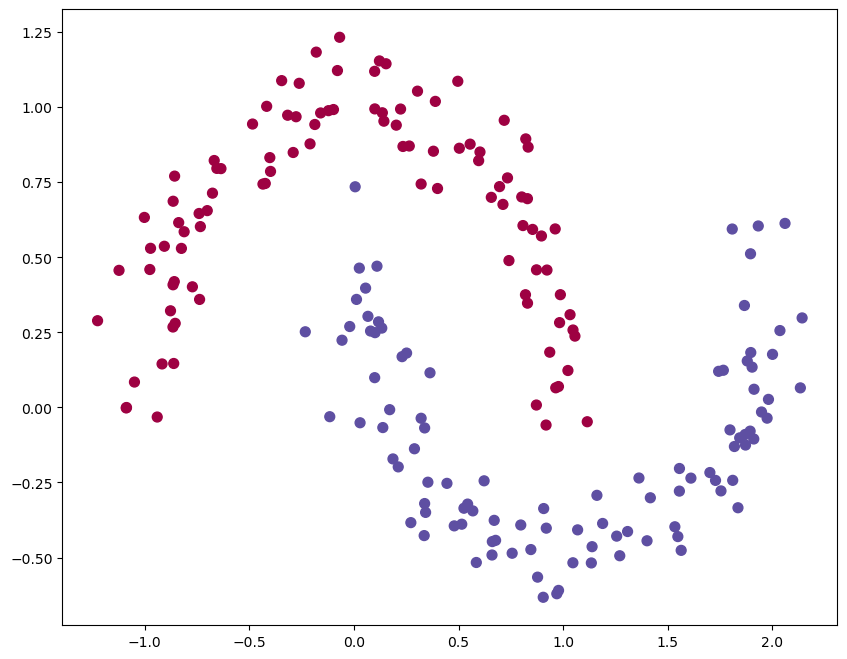

In [159]:
plt.scatter(X[:,0], X[:,1], s=50, c=y+1, cmap=plt.cm.Spectral)
plt.show()

L'ensemble de données que nous avons généré comporte deux classes, représentées par des points rouges et bleus. Vous pouvez considérer les points bleus comme des patients sains et les points rouges comme des patients malades, les axes $x_1$ et $x_2$ étant des mesures médicales.

Notre objectif est d'entraîner un classificateur d'apprentissage automatique qui prédit la classe correcte (sain ou malade) à partir des coordonnées $x_1$ et $x_2$.

# Trouver la meilleur droite manuellement

Dans cette partie nous allons essayer de trouver la meilleure droite qui sépare notre nuage de points manuellement.

<font color='red'><b>Question 1</b></font>  Crée une fonction qui renvoie 1 si un point de coordonnées $(x_1,x_2$) est en dessous de la droite de coefficient directeur $a$ et d'ordonnée à l'origine $b$.

In [160]:
def pred_linear(a: float, b: float, x1: float, x2: float):
    if a* x1 + b > x2:
        return 1 
    else: 
        return 0

In [161]:
#Exemple
# (1,1) est au-dessous de la droite d'equation x+2
print(pred_linear(1,2,1,1))

1


Il est important de pouvoir évaluer les performances de nos approches grâce à des métriques. Ici, on choisira l'accuracy qui est simplement le nombre d'éléments bien classifié divisé par le nombre total d'éléments.

Pour en savoir plus sur les métriques de classification comme la précision, le rappel et leur lien avec l'accuracy, vous pouvez consulter l'excellente Wikipedia suivante (si vous comptez faire du Machine Learning par la suite, la notion de précision/rappel est un classique) https://en.wikipedia.org/wiki/Precision_and_recall

<font color='red'><b>Question 2.</b></font> Compléter la fonction accuracy suivante. (1 ligne Python avec une compréhension de liste)

In [162]:
def accuracy(y_true, y_pred):
    """
    Args:
        y_true (list[int]): liste d'entier dans {0,1} contenant les labels
        y_pred (list[int]): liste d'entier dans {0,1} contenant les prédictions du modèle

    Returns:
        float: Accuracy du modèle
    """
    return sum([1 for vrai_y,pred_y in zip(y_true,y_pred)if vrai_y==pred_y] )/len(y_pred)

In [163]:
#### fonction d'affichage
def plot_decision_boundary(pred_func):
    """
    Affiche les frontières de décision d'une fonction de prédiction binaire.
    """
    # Définir les dimensions de la grille et donner un peu de marge pour l'affichage
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.01
    # Générer la grille de points avec un distance de h entre eux
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Tracer la frontière de décision
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Afficher le contour et les points d'entrainements
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

<font color='red'><b>Question 3.</b></font>  Jouez à la main avec des paramètres $a$ et $b$ pour obtenir plusieurs frontrières de décisions linéaires et essayez d'obtenir au moins 80% d'accuracy.



le score obtenu est de:  0.84


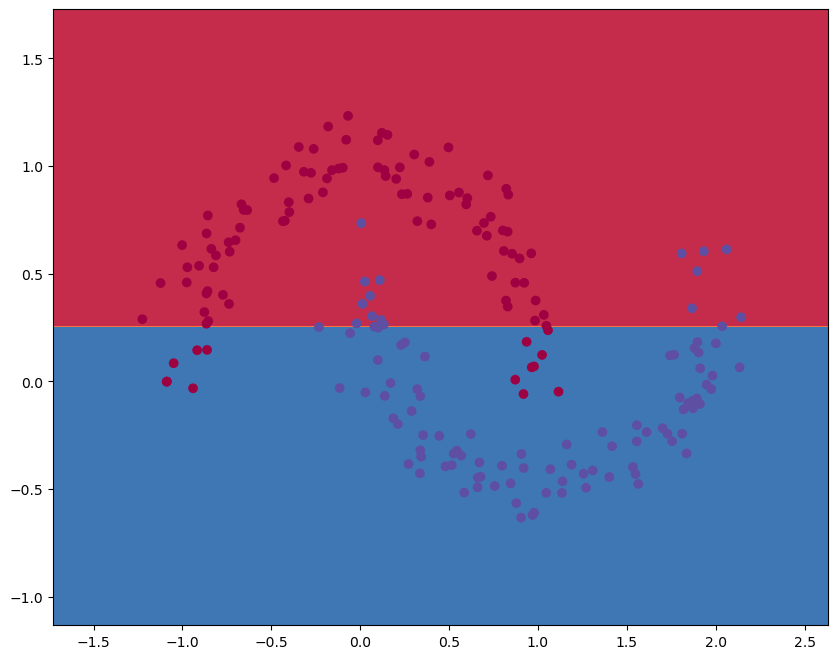

In [164]:
a = 0
b = 0.25
def prediction(A, a, b, func):
    return np.array([func(a=a, b=b, x1=x[0], x2=x[1]) for x in A])
plot_decision_boundary(lambda x: prediction(x, a, b, pred_linear))
print('le score obtenu est de: ', accuracy(y, prediction(X, a, b, pred_linear)))

# Régression Logistique

Scikit-learn possède des modèles tels que la régression logistique qui permet de trouver les paramètres a et b optimaux:

In [165]:
classifier = sklearn.linear_model.LogisticRegressionCV()

 <font color='red'><b>Question 4.</b></font> Entraîner ce modèle de régression logistique sur le dataset (X,y). Vous pouvez vous aider de la documentation de Scikit-learn pour voir comment entrainer un modèle sur des données : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [166]:
# Importer la librairie
from sklearn.linear_model import LogisticRegression

# Créer le modèle de régression logistique
classifier = LogisticRegression()

# Entraîner le modèle sur les données (X, y)
classifier.fit(X, y)

# Afficher les paramètres a et b optimaux trouvés par le modèle
print("Coefficients (a) : ", classifier.coef_)
print("Biais (b) : ", classifier.intercept_)


Coefficients (a) :  [[ 1.08951652 -3.61701556]]
Biais (b) :  [0.42030078]


Une fois le modèle entrainé, on peut l'utiliser pour prédire et tracer la frontière de décision :

le score obtenu est de:  0.87


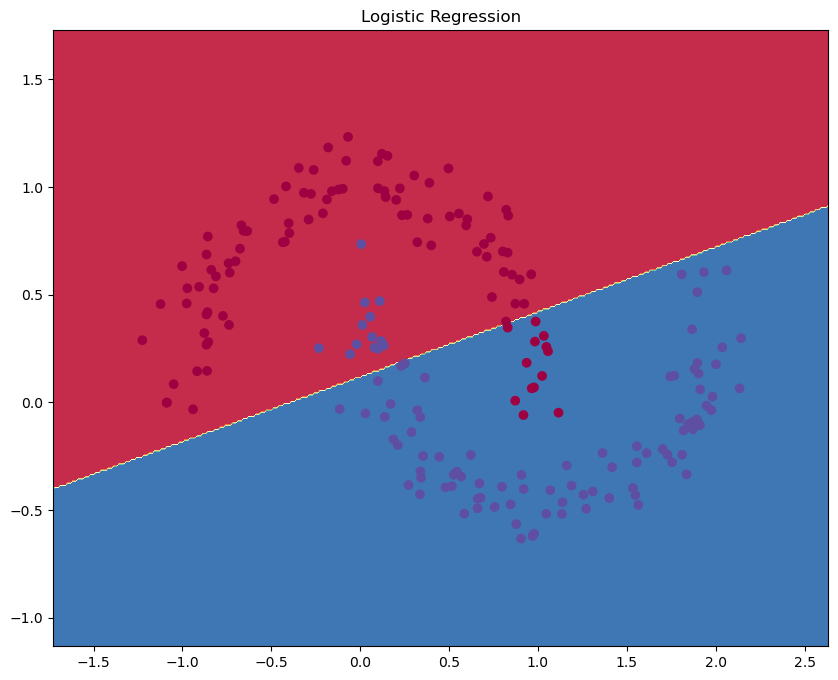

In [167]:
plot_decision_boundary(lambda x: classifier.predict(x))
plt.title("Logistic Regression")
print('le score obtenu est de: ', accuracy(y, classifier.predict(X)))

 <font color='red'><b>Question 5.</b></font> Qu'observez vous ? Est ce que un tel résultat était prévisible ? Que faire pour améliorer nos prédictions ?

Visuellement, le dataset ne semble pas linéairement séparable. En effet, étant donné que notre jeu de données ne comporte que deux caractéristiques, la recherche d'une frontière de décision se traduit ici par la recherche d'une droite de séparation. Or, le modèle de régression logistique est un classificateur linéaire, c’est-à-dire qu’il est limité à l’apprentissage de frontières linéaires. Cette contrainte structurelle explique donc les faibles performances observées du modèle, celui-ci n’étant pas capable de capturer des structures non linéaires présentes dans les données.

# Réseau de neurones

Vous allez maintenant créer un réseau de neurones pour résoudre le probleme précédent.

 <font color='red'><b> Question 6</b></font> Compléter les variables et les fonctions suivantes pour coder un réseau de neurones à **deux couches** (1 couche cachée). Chaque couche cachée aura pour l'instant **10 neurones** et on utilisera un learning rate de 1e-1.

In [ ]:
# nombre d'exemples dans la base d'entrainement
N = 200

# dimension de l'entrée du réseau
d_input = 2

# dimension de la sortie du réseau
d_output = 2 #car nous avons deux classes (0 et 1)

# dimension des couches cachées i.e. nombre de neurones des couches cachées
d_hidden = 10

# Paramètres de la descente de gradient :
# learning rate pour la descente de gradient
epsilon = 1e-1

In [146]:
def init_model(d_input: int, d_hidden: int, d_output: int):
    """
    Args:
        d_input (int): dimension de l'entrée du réseau
        d_hidden (int): dimension des couches cachée
        d_output (int): dimension de la sortie du réseau

    Returns:
        dict: Dictionnaire contenant 4 clefs, les poids/biais (W1,b1) et (W2,b2) du réseau de neurone.
    """
    # Initialisation des paramètes aléatoires
    random.seed(0)

    # Première couche de taille d_input x d_hidden
    W1 =[[random.random()-0.5 for _ in range(d_hidden)] for _ in range(d_input)]
    #-0.5 parce que random.random genere des valeurs entre [0,1] donc on se ramene la bonne plage

    # Biais de la première couche vecteur de taille d_hidden
    b1 = [random.random()-0.5 for _ in range(d_hidden)]

    # Seconde couche de taille d_hidden x d_output
    W2 = [[random.random()-0.5 for _ in range(d_output)] for _ in range(d_hidden)]

    # Biais de la seconde couche vecteur de taille d_output
    b2 = [random.random()-0.5 for _ in range(d_output)]

    # Le modèle retourné à la fin, c'est un dictionnaire des poids et de biais
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

    return model

In [147]:
model=init_model(d_input,d_hidden,d_output)
W1=model['W1']
b1=model['b1']

print(W1)
print(len(W1)) #2 neurones donc 2 lignes
print(len(W1[0])) #10 colonnes car 10 neurones

[[0.3444218515250481, 0.2579544029403025, -0.079428419169155, -0.24108324970703665, 0.01127472136860852, -0.09506586254958571, 0.2837985890347726, -0.19668727392107255, -0.02340304584764419, 0.0833820394550312], [0.4081128851953352, 0.004686855817390256, -0.21816215560029617, 0.25580420415722394, 0.11836899667533163, -0.24949365863755946, 0.4097462559682401, 0.4827854760376531, 0.31021723599658957, 0.4021659504395827]]
2
10


 <font color='red'><b> Question 8</b></font> Compléter la fonction forward_layer en effectuant l'opération suivante:
 $$ X \times W + b $$
 Dans laquelle X représente l'entrée, W les poids et b les biais.
 Compléter la fonction sigmoid et feed_forward.

In [148]:
def forward_layer(X, W, b):
    return np.dot(X,W)+b
#Cacul de Z1, par exemple
print(forward_layer(X[0],W1,b1))
#vecteur de dimension (1,10)


[-0.51683546 -0.04047647  0.46377033  0.45858368 -0.02969388 -0.32060213
 -0.32905365  0.35806334  0.46376637  0.41306306]


In [149]:
def sigmoid(x):
    """"
    Args:
        x (float): input
    returns:
        float : sigmoid(x)

    """
    return 1/(1+np.exp(-x))


In [150]:
print(sigmoid(forward_layer(X[0],W1,b1)))
#On passe le vecteur Z1 a la fonction sigmoide pour obtenir A1, les valeurs et dimensions sont coherente, nous obtenons des valeurs entre [0,1]

[0.37359251 0.48988226 0.61390822 0.61267813 0.49257708 0.42052901
 0.4184709  0.58857154 0.61390728 0.60182212]


In [151]:
def softmax(z):
    """
    Args:
        z (list of float): Entrée de la fonction softmax

    Returns:
        list of float: Probabilités normalisées
    """
    z=np.array(z)
    exp_z=np.exp(z)
    sum_expz=np.sum(exp_z)
    return exp_z/sum_expz

In [152]:
print(softmax([1,5.95,6]))
#Quand on somme les valeurs on tombe bien sur 1, ce sont bien des probabilités

[0.0034413  0.48582496 0.51073374]


In [169]:
def forward_function(X,W1,b1,W2,b2):
    """
    Effectue une passe avant dans le réseau de neurones.

    Args:
        X (list of list of float): Entrée du réseau
        W1 (list of list of float): Poids de la première couche
        b1 (list of float): Biais de la première couche
        W2 (list of list of float): Poids de la seconde couche
        b2 (list of float): Biais de la seconde couche

    Returns:
        list of list of float: Probabilités de sortie après la softmax
    """
    Z1=forward_layer(X, W1, b1) #Vecteur de dimension (1,10)
    A1=sigmoid(Z1) #Vecteur de dimension (1,10)
    Z2=forward_layer(A1, W2, b2) #Vecteur de dimension (1,2)
    A2=softmax(Z2) #Vecteur de probabilité de dimension (1,2)
    return A2


In [170]:
# Tester votre résultat :
np.random.seed(1)
model_test = init_model(4,3,2)
X_debug = np.random.rand(1,4)
forward_function(X_debug, model_test['W1'], model_test['b1'], model_test['W2'], model_test['b2']) 

array([[0.48597225, 0.51402775]])

Vous êtes censés trouver, avec la même seed  : [[0.69, 0.31]].

 <font color='red'><b> Question 9</b></font> Donner les dimensions des différentes quantités ($Z^{(1)}$, $Z^{(2)}$, $A^{(1)}$, $A^{(2)}$), compléter  les équations de la back propagation et donnez les dimensions des dérivées partielles de la fonction de perte. Est-ce que cela vous semble logique avec les dimensions des paramètres ?


$$
\begin{aligned}
Z^{(1)} & = X_iW^{(1)} + B^{(1)}  \\
A^{(1)} & = sigmoid(Z^{(1)})=\frac{1}{1+\exp(-Z^{(1)})} \\
Z^{(2)} & = A^{(1)}W^{(2)} + B^{(2)} \\
A^{(2)} & = \hat{y} = \mathrm{softmax}(Z^{(2)})\\
\ell_i(y,\hat{y}) & = - \sum_{c=1}^C y_{i,c} \log\hat{y}_{i,c} \: \textrm{avec $C$ le nombre de classes}
\end{aligned}
$$



Les dimensions:
$$\text{dim}(Z^{(1)}) = (1, 10)$$

$$\text{dim}(W^{(1)}) = (2, 10)$$

$$\text{dim}(Z^{(2)}) = (1, 2)$$

$$\text{dim}(A^{(2)}) = (1, 2)$$

Back propagation :
$$\Delta^{(1)}= (\Delta^{(2)} \times (W^{(2)})^T) \times \frac{\partial A^{(1)}}{\partial Z^{(1)}}$$
$$\Delta^{(2)}=\frac{\partial\ell_i}{\partial A^{(2)}} \times \frac{\partial A^{(2)}}{\partial Z^{(2)}}=A^{(2)}−y_{i}$$
$$\frac{\partial{\ell_i}}{\partial{W^{(2)}}}=(A^{(1)})^T \times \Delta^{(2)}$$
$$\frac{\partial{\ell_i}}{\partial{B^{(2)}}}=\Delta^{(2)}$$
$$\frac{\partial{\ell_i}}{\partial{W^{(1)}}}= X^T \times \Delta^{(1)}$$
$$\frac{\partial{\ell_i}}{\partial{B^{(1)}}}= \Delta^{(1)}$$
$$\frac{\partial A^{(1)}}{\partial Z^{(1)}} = A^{(1)} \odot (1 - A^{(1)})$$
$$ \odot \text{ est le produit terme à terme d'Hadamard (Les matrices sont diagonales)} $$
Dimensions des matrices:
$$\text{dim}(\Delta^{(2)}) = (1, 2)$$
$$\text{dim}(W^{(2)}) = (10, 2)$$
$$\text{dim}((W^{(2)})^T) = (2, 10)$$
$$\text{dim}\left(\frac{\partial A^{(1)}}{\partial Z^{(1)}}\right) = (10, 10) \text{ (En pratique ce sera plutôt } (1,10) \text{ car avec la fonction sigmoid, chaque activation ne dépend que de son propre } Z_i \text{)}$$
$$\text{dim}(\Delta^{(1)}) = (1, 10)$$
$$\text{dim}(A^{(1)}) = (1, 10)$$
$$\text{dim}((A^{(1)})^T) = (10, 1)$$
$$\text{dim}\left(\frac{\partial{\ell_i}}{\partial{W^{(2)}}}\right) = (10, 2)$$
$$\text{dim}\left(\frac{\partial{\ell_i}}{\partial{B^{(2)}}}\right) = (1, 2)$$
$$\text{dim}(X) = (1, 2)$$
$$\text{dim}(X^T) = (2, 1)$$
$$\text{dim}\left(\frac{\partial{\ell_i}}{\partial{W^{(1)}}}\right) = (2, 10)$$
$$\text{dim}\left(\frac{\partial{\ell_i}}{\partial{B^{(1)}}}\right) = (1, 10)$$






 <font color='red'><b> Question 10</b></font> Complétez la fonction train_model.

In [ ]:
def train_model(X, y, model, num_epochs=1, num_classes= d_output, print_loss=False):
   W1 = model['W1']
   b1 = model['b1']
   W2 = model['W2']
   b2 = model['b2']

   correct_logprobs = 0

   # Gradient descent. For each batch...
   for i in range(0, num_epochs):
     epoch_loss = 0
     X_shuffled, y_shuffled = shuffle(X, y) #### j'ai mélangé mes données uniformément

     for Xi, yi in zip(X_shuffled, y_shuffled):

       # One-hot encodé y de la forme (1,0) ou (0,1) ,num_classe=2
       yi = np.eye(num_classes)[yi]
       Z1 = forward_layer(Xi, W1, b1) #Vecteur de dimension (1,10)
       A1 = sigmoid(Z1) #Vecteur de dimension (1,10)
       Z2 = forward_layer(A1, W2, b2) #Vecteur de dimension (1,2)
       A2 = softmax(Z2) #Vecteur de probabilité de dimension (1,2)
       y_pred = A2
       # Calcul de la loss (c)
       #loss = yi[0] * np.log(y_pred[0]) + yi[1] * np.log(y_pred[1])
       loss = -np.sum(yi * np.log(y_pred)) #Version generalise pour Mnist
       epoch_loss +=loss

       # Backpropagation
       delta_2 = A2 - yi
       delta_1 = np.dot(delta_2, np.transpose(W2)) * (A1 * (1 - A1)) #Produit terme a terme
       d_b2 = delta_2
       d_b1 = delta_1
       d_w1 = np.dot(Xi.reshape(-1, 1), delta_1.reshape(1, -1)) #reshape pour passer de (2,) et (,10) a (2,1) et (1,10)
       d_w2 = np.dot(A1.reshape(-1, 1), delta_2.reshape(1, -1))

       #Mise a jour poids+biais
       # Descente de gradient
       W2 = W2 - epsilon * d_w2
       W1 = W1 - epsilon * d_w1
       b1 = b1 - epsilon * d_b1
       b2 = b2 - epsilon * d_b2
       # Mise à jour des poids et des biais
       model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

     correct_logprobs=epoch_loss

     # Affichage de la loss
     if print_loss and i % 51 == 0:
       print("Loss a l'époque %i: %f" %(i, correct_logprobs))

   return model

Nous aurons besoin d'une fonction de prédiction qui se sert de notre modèle entrainé pour renvoyer des prédictions. Contrairement aux sorties du modèle qui sont des float dans [0,1] pour chaque classe, la prédiction du modèle vaut 1 sur la classe dont le score est maximale et 0 ailleurs. On utilise la fonction argmax de numpy pour faire cela automatiquement.

<font color='red'><b> Question 11</b></font> Compléter la fonction predict() :

In [203]:
def predict(model, X_predict):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    return np.argmax(forward_function(X_predict,W1,b1,W2,b2),axis=1)
#Retourne l'index du coefficient du vecteur ayant la proba maximale

<font color='red'><b> Question 12</b></font> Entrainer le modele pour différents nombre d'epochs et commenter vos résultats.

In [209]:
model = init_model(d_input,d_hidden,d_output)
model = train_model(X,y,model,num_epochs=51,print_loss=True)
print("L'accuracy finale obtenue est de :", accuracy(y, predict(model, X)))


Loss a l'époque 0: -118.729995
Loss a l'époque 50: -55.848435
L'accuracy finale obtenue est de : 0.875


In [215]:
# Liste des nombres d'époques à tester
epochs_to_test = [1, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150]

# Dictionnaire pour stocker les résultats
results = {}

# Boucle de test
for num_epochs in epochs_to_test:
    print(f"\n--- Test avec {num_epochs} époques ---")
    
    # Ré-initialisation du modèle à chaque fois
    model = init_model(d_input, d_hidden, d_output)
    
    # Entraînement du modèle
    model = train_model(X, y, model, num_epochs=num_epochs, print_loss=True)
    
    # Calcul de l'accuracy
    accuracy_score = accuracy(y, predict(model, X))
    
    # Stockage du résultat
    results[num_epochs] = accuracy_score
    
    print(f"L'accuracy finale obtenue est de : {accuracy_score}")

# Affichage récapitulatif des résultats
print("\n--- Récapitulatif des résultats ---")
for epochs, acc in results.items():
    print(f"{epochs} époques : {acc}")


--- Test avec 1 époques ---
Loss a l'époque 0: -117.041692
L'accuracy finale obtenue est de : 0.795

--- Test avec 15 époques ---
Loss a l'époque 0: -117.709542
L'accuracy finale obtenue est de : 0.85

--- Test avec 30 époques ---
Loss a l'époque 0: -115.421477
L'accuracy finale obtenue est de : 0.85

--- Test avec 45 époques ---
Loss a l'époque 0: -118.393712
L'accuracy finale obtenue est de : 0.855

--- Test avec 60 époques ---
Loss a l'époque 0: -115.214780
Loss a l'époque 50: -57.994364
L'accuracy finale obtenue est de : 0.87

--- Test avec 75 époques ---
Loss a l'époque 0: -118.075536
Loss a l'époque 50: -57.786256
L'accuracy finale obtenue est de : 0.855

--- Test avec 90 époques ---
Loss a l'époque 0: -118.162026
Loss a l'époque 50: -56.716756
L'accuracy finale obtenue est de : 0.865

--- Test avec 105 époques ---
Loss a l'époque 0: -115.244448
Loss a l'époque 50: -58.508902
Loss a l'époque 100: -42.875449
L'accuracy finale obtenue est de : 0.93

--- Test avec 120 époques ---
L

Le réseau de neurones a significativement surpassé la régression logistique, passant de 81% à 100% d'accuracy, grâce à sa capacité à modéliser des frontières de décision non linéaires. La structure avec une couche cachée et l'activation sigmoid permet de capturer la complexité intriquée du jeu de données "make_moons", que la régression logistique ne pouvait pas représenter. L'apprentissage s'améliore progressivement avec le nombre d'époques, atteignant une performance optimale entre 105 et 120 époques. Bien que le modèle atteigne 100% d'accuracy à 150 époques, il convient de rester vigilant quant à un possible surapprentissage, en trouvant un équilibre judicieux entre performance computationnelle et capacité de généralisation.RéessayerClaude peut faire des erreurs. Assurez-vous de vérifier ses réponses.

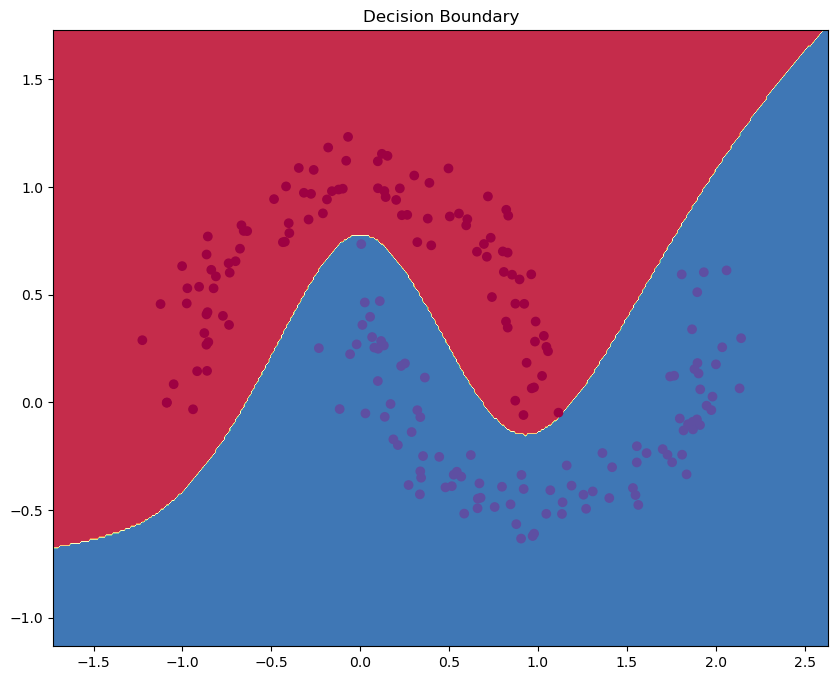

In [216]:
#Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary");

# Application sur un vrai jeu de données (pour le rendu du TP)

Nous allons maintenant appliquer notre modèle sur un vrai jeu de donnée bien connu dans le monde du Machine Learning : le MNIST (https://en.wikipedia.org/wiki/MNIST_database) qui est dans Sklearn.

1797


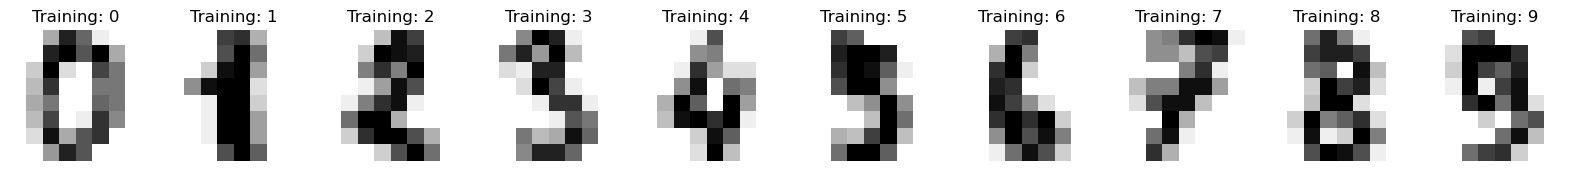

In [ ]:
digits = sklearn.datasets.load_digits()
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)



In [229]:
X_real =  digits.images.reshape((n_samples, -1)) # On reshape les images en vecteur
y_real = digits.target
print(X_real.shape)
print(y_real.shape)

(1797, 64)
(1797,)


<font color='red'><b> Question 13 </b></font> Compléter les dimensions d'entrée et de sortie de votre réseau pour qu'il soit adapté au Dataset MNIST et relancer l'entrainement (attention, l'entrainement prendra maintenant quelques minutes sans optimisation du code supplémentaire).

In [ ]:
N = len(X_real)
d_input = 64
d_output = 10
d_hidden = 2

# Parametre de la descente de gradient
epsilon = 0.0001 # le learning rate doit être plus petit qu'avant sinon l'entrainement diverge

In [235]:
model = init_model(d_input,d_hidden,d_output)
model = train_model(X_real, y_real, model, num_epochs=1000, num_classes= d_output, print_loss=True)
print("L'accuracy finale obtenue est de :", accuracy(y, predict(model, X_real)))

Loss a l'époque 0: -653.893710
Loss a l'époque 50: -752.447600
Loss a l'époque 100: -721.057991
Loss a l'époque 150: -688.266152
Loss a l'époque 200: -668.361281
Loss a l'époque 250: -654.027607
Loss a l'époque 300: -644.778335
Loss a l'époque 350: -638.604596
Loss a l'époque 400: -630.312835
Loss a l'époque 450: -622.024404
Loss a l'époque 500: -618.256713
Loss a l'époque 550: -614.154780
Loss a l'époque 600: -609.017637
Loss a l'époque 650: -605.274192
Loss a l'époque 700: -602.422818
Loss a l'époque 750: -600.183684
Loss a l'époque 800: -595.663104
Loss a l'époque 850: -593.648557
Loss a l'époque 900: -592.139715
Loss a l'époque 950: -590.506327
L'accuracy finale obtenue est de : 0.0


<font color='red'><b> Questions 14  </b></font> Comment rendre votre réseau de neurones plus performant ? (Donnez ici seulement des idées.)

Pour améliorer les performances de votre réseau de neurones, vous pouvez expérimenter avec différentes architectures en modifiant le nombre de couches cachées et de neurones par couche, et même essayer des architectures plus avancées comme les réseaux convolutifs (CNN) pour les images. L'initialisation des poids joue également un rôle important dans la convergence du modèle, surtout lorsqu'on utilise des fonctions d'activation comme ReLU. La régularisation L2 peut aider à réduire le surapprentissage. Il est aussi crucial d'optimiser les hyperparamètres tels que le taux d'apprentissage et la taille des lots (batch size) en utilisant des techniques comme la recherche sur grille. Enfin, le prétraitement des données, comme la normalisation ou la standardisation des entrées et l'augmentation de données par des transformations comme les rotations et les translations, peut contribuer à améliorer les performances en augmentant la taille et la diversité des données d'entraînement.RéessayerClaude peut faire des erreurs. Assurez-vous de vérifier ses réponses.